# Constraint Satisfaction Matcher

The ConstraintSatisfactionMatcher can be used to optimize any linear function of the baseline covariates. In this demo notebook, we show how to call the matcher in the PyBalance library.

In [1]:
import logging 
logging.basicConfig(
    format="%(levelname)-4s [%(filename)s:%(lineno)d] %(message)s",
    level='INFO',
)
from pybalance.utils import (
    BetaBalance, 
    BetaXBalance, 
    GammaBalance, 
    GammaXBalance,
    GammaXTreeBalance
)
from pybalance.sim import generate_toy_dataset
from pybalance.lp import ConstraintSatisfactionMatcher
from pybalance.visualization import (
    plot_numeric_features, 
    plot_categoric_features, 
    plot_binary_features,
    plot_per_feature_loss,
)

In [2]:
time_limit = 360

In [3]:
m = generate_toy_dataset()
m

## Optimize Beta (Mean Absolute SMD)

In [4]:
objective = beta = BetaBalance(m)
matcher = matcher_beta = ConstraintSatisfactionMatcher(
    m, 
    time_limit=time_limit,
    objective=objective,
    ps_hinting=False,
    num_workers=4)
matcher.get_params()

INFO [matcher.py:65] Scaling features by factor 240.00 in order to use integer solver with <= 0.2841% loss.


{'objective': 'beta',
 'pool_size': 1000,
 'target_size': 1000,
 'max_mismatch': None,
 'time_limit': 360,
 'num_workers': 4,
 'ps_hinting': False,
 'verbose': True}

In [5]:
matcher.match()

INFO [matcher.py:418] Solving for match population with pool size = 1000 and target size = 1000 subject to None balance constraint.
INFO [matcher.py:421] Matching on 15 dimensions ...
INFO [matcher.py:428] Building model variables and constraints ...
INFO [matcher.py:437] Calculating bounds on feature variables ...
INFO [matcher.py:527] Applying size constraints on pool and target ...
INFO [matcher.py:611] Solving with 4 workers ...
INFO [matcher.py:90] Initial balance score: 0.2328
INFO [matcher.py:96] =========================================
INFO [matcher.py:97] Solution 1, time = 0.02 m
INFO [matcher.py:101] Objective:	452948000.0
INFO [matcher.py:120] Balance (beta):	0.2298
INFO [matcher.py:125] Patients (pool):	1000
INFO [matcher.py:126] Patients (target):	1000
INFO [matcher.py:140]  
INFO [matcher.py:96] =========================================
INFO [matcher.py:97] Solution 2, time = 0.03 m
INFO [matcher.py:101] Objective:	452876000.0
INFO [matcher.py:120] Balance (beta):	0.229

Note that it is possible for the "balance" value to go up (hopefully only slightly) as the solver progresses. This behavior is due to rounding errors incurred when casting a continuous problem into the discrete space understood by the solver. The "balance" reported here is the actual balance computed to full accuracy on the original dataset; the "objective" value here is the actual quantity being optimized and should never increase.

In [6]:
matcher.get_best_match()

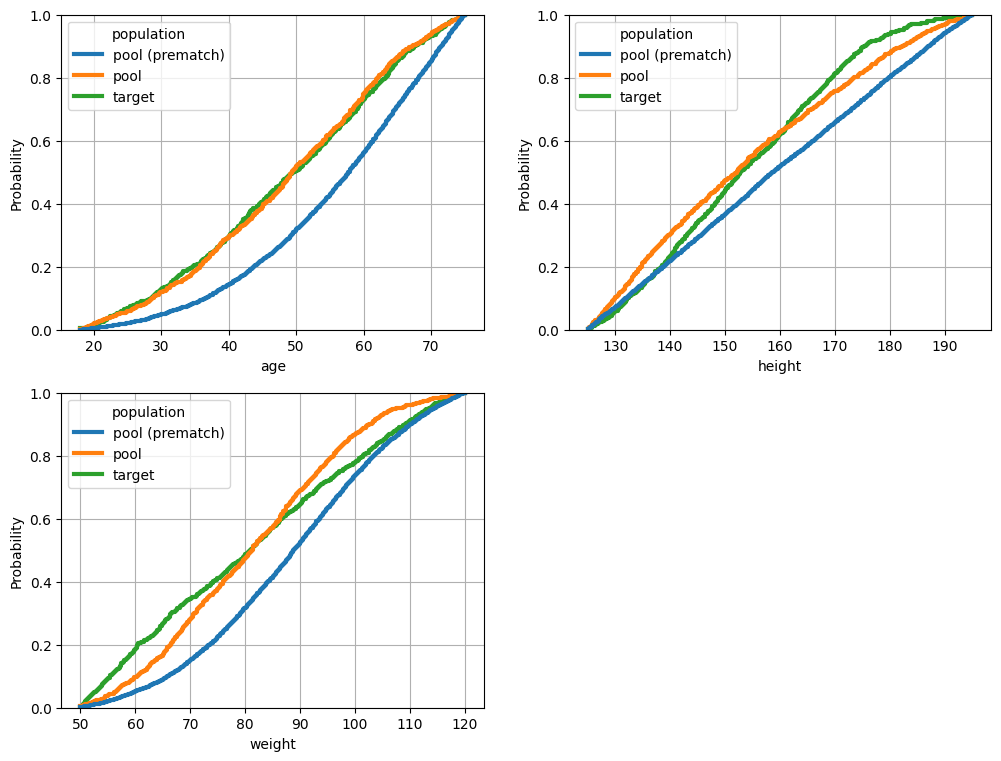

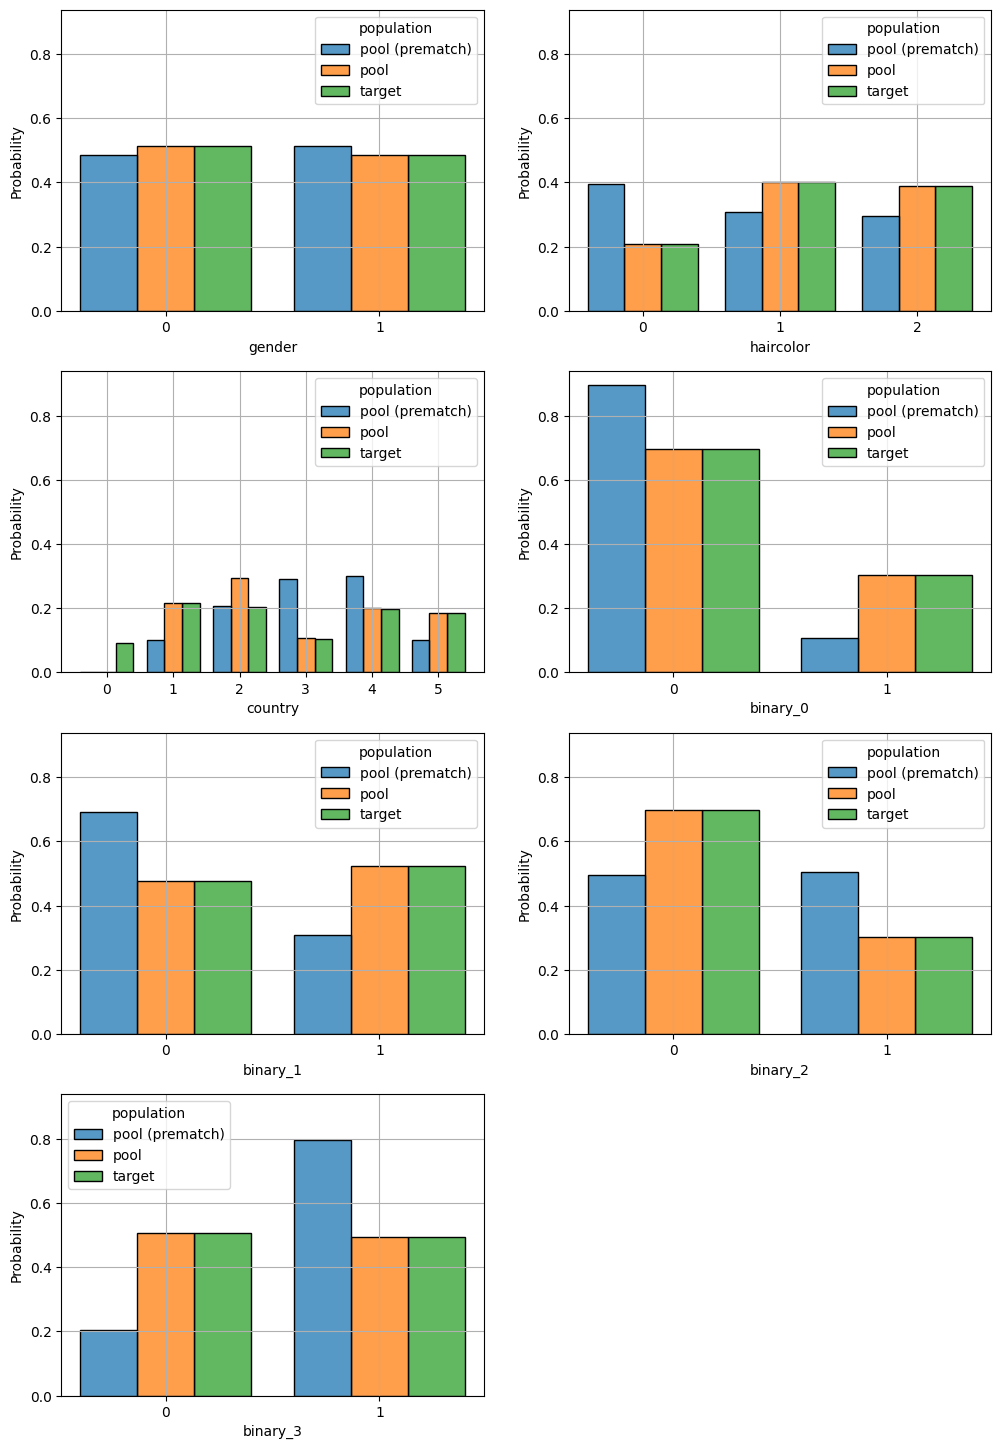

In [7]:
%matplotlib inline

match = matcher.get_best_match()
m_data = m.copy().get_population('pool')
m_data.loc[:, 'population'] = m_data['population'] + ' (prematch)'
match.append(m_data)
# fig = plot_per_feature_loss(match, beta, 'target', debin=False)
fig = plot_numeric_features(match, hue_order=['pool (prematch)', 'pool', 'target', ])
fig = plot_categoric_features(match,  hue_order=['pool (prematch)', 'pool', 'target'])


## Optimize Beta With Cross Terms Added

Sometimes it helps to add a known (non-optimal) solution as a hint to the solver. A natural choice for hinting the solver is to take a solution from PS matching. We can choose to use the PS as a hint to the solver by passing ps_hinting=True.

In [8]:
objective = beta_x = BetaXBalance(m)
matcher = matcher_betax = ConstraintSatisfactionMatcher(
    m, 
    time_limit=time_limit,
    objective=objective,
    ps_hinting=True,
    num_workers=4)
matcher.get_params()

INFO [preprocess.py:442] Added cross term height * weight to matching features.
INFO [preprocess.py:442] Added cross term gender * age to matching features.
INFO [preprocess.py:442] Added cross term binary_0 * binary_3 to matching features.
INFO [preprocess.py:442] Added cross term binary_0 * age to matching features.
INFO [preprocess.py:442] Added cross term binary_3 * weight to matching features.
INFO [preprocess.py:442] Added cross term binary_2 * weight to matching features.
INFO [preprocess.py:442] Added cross term binary_1 * binary_3 to matching features.
INFO [preprocess.py:442] Added cross term binary_2 * binary_3 to matching features.
INFO [preprocess.py:442] Added cross term binary_2 * height to matching features.
INFO [preprocess.py:442] Added cross term binary_0 * binary_2 to matching features.
INFO [matcher.py:65] Scaling features by factor 240.00 in order to use integer solver with <= 0.3751% loss.


{'objective': 'beta_x',
 'pool_size': 1000,
 'target_size': 1000,
 'max_mismatch': None,
 'time_limit': 360,
 'num_workers': 4,
 'ps_hinting': True,
 'verbose': True}

In [9]:
matcher.match()

INFO [matcher.py:418] Solving for match population with pool size = 1000 and target size = 1000 subject to None balance constraint.
INFO [matcher.py:421] Matching on 25 dimensions ...
INFO [matcher.py:428] Building model variables and constraints ...
INFO [matcher.py:437] Calculating bounds on feature variables ...
INFO [matcher.py:527] Applying size constraints on pool and target ...
INFO [matcher.py:533] Applying hint ...
INFO [matcher.py:540] Training PS model as guide for solver ...
/opt/miniconda3/envs/pybalance/lib/python3.9/site-packages/pybalance/lp/matcher.py:542: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.loc[:, "ix"] = list(range(len(target)))
/opt/miniconda3/envs/pybalance/lib/python3.9/site-packages/pybalance/lp/matcher.py:

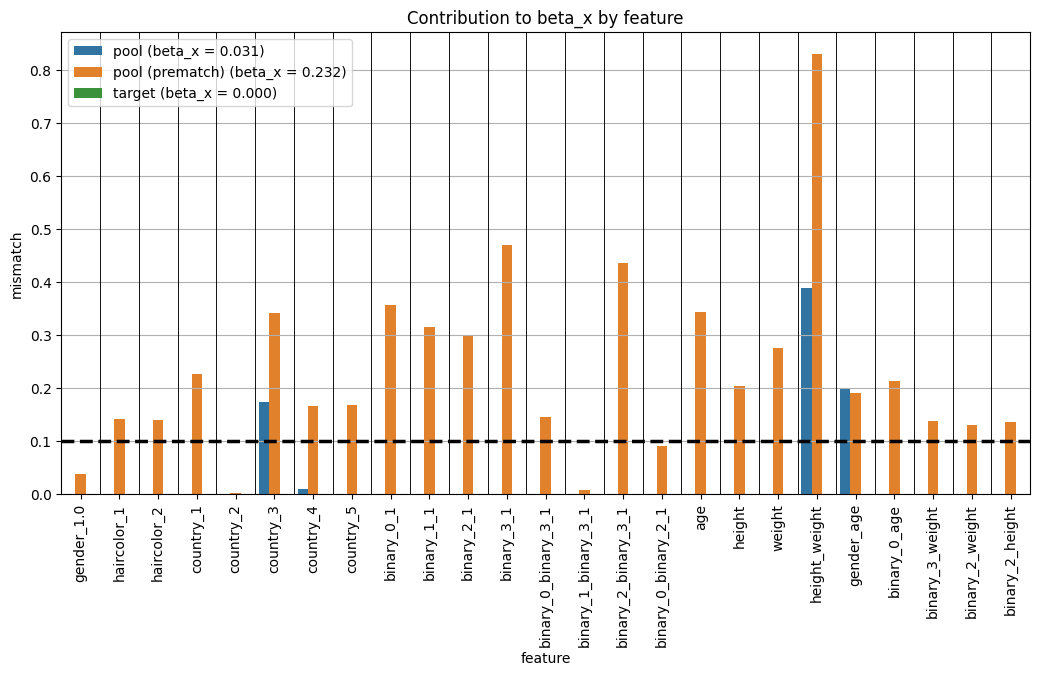

In [10]:
%matplotlib inline

match = matcher.get_best_match()
m_data = m.copy().get_population('pool')
m_data.loc[:, 'population'] = m_data['population'] + ' (prematch)'
match.append(m_data)
fig = plot_per_feature_loss(match, objective, 'target', debin=False)

## Optimize Gamma (Area Between CDFs)

In [11]:
objective = gamma = GammaBalance(m)
matcher = matcher_gamma = ConstraintSatisfactionMatcher(
    m, 
    time_limit=time_limit,
    objective=objective,
    ps_hinting=True,
    num_workers=4)
matcher.get_params()

INFO [preprocess.py:335] Discretized age with bins [18.05, 27.54, 37.04, 46.53, 56.02, 65.51, 75.0].
INFO [preprocess.py:335] Discretized height with bins [125.01, 136.68, 148.34, 160.01, 171.67, 183.34, 195.0].
INFO [preprocess.py:335] Discretized weight with bins [50.0, 61.67, 73.33, 85.0, 96.66, 108.33, 120.0].
INFO [matcher.py:65] Scaling features by factor 200.00 in order to use integer solver with <= 0.0000% loss.


{'objective': 'gamma',
 'pool_size': 1000,
 'target_size': 1000,
 'max_mismatch': None,
 'time_limit': 360,
 'num_workers': 4,
 'ps_hinting': True,
 'verbose': True}

In [12]:
matcher.match()

INFO [matcher.py:418] Solving for match population with pool size = 1000 and target size = 1000 subject to None balance constraint.
INFO [matcher.py:421] Matching on 27 dimensions ...
INFO [matcher.py:428] Building model variables and constraints ...
INFO [matcher.py:437] Calculating bounds on feature variables ...
INFO [matcher.py:527] Applying size constraints on pool and target ...
INFO [matcher.py:533] Applying hint ...
INFO [matcher.py:540] Training PS model as guide for solver ...
/opt/miniconda3/envs/pybalance/lib/python3.9/site-packages/pybalance/lp/matcher.py:542: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.loc[:, "ix"] = list(range(len(target)))
/opt/miniconda3/envs/pybalance/lib/python3.9/site-packages/pybalance/lp/matcher.py:

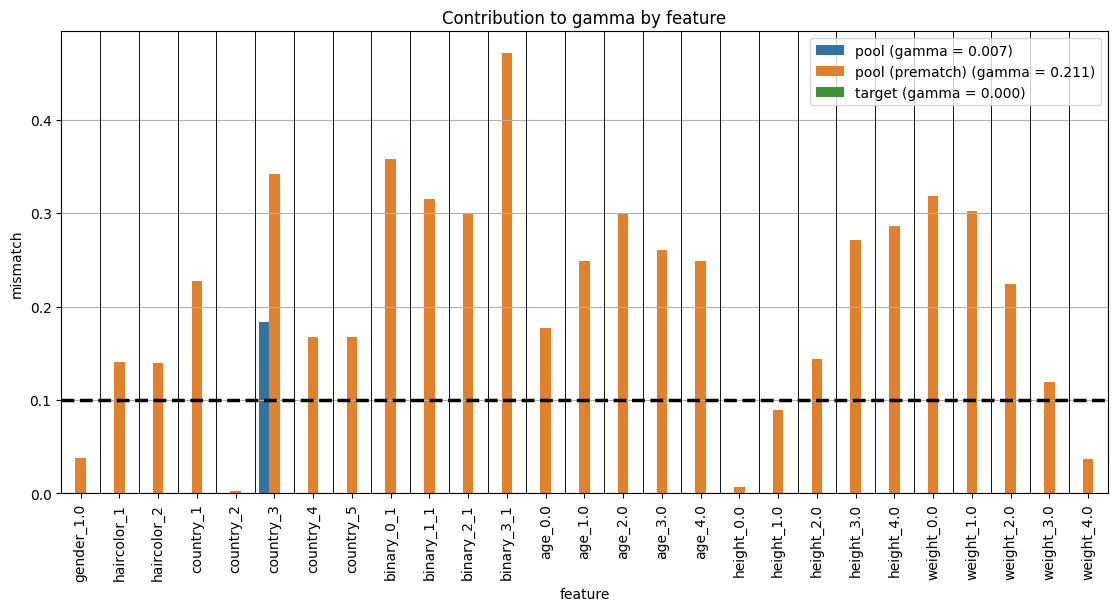

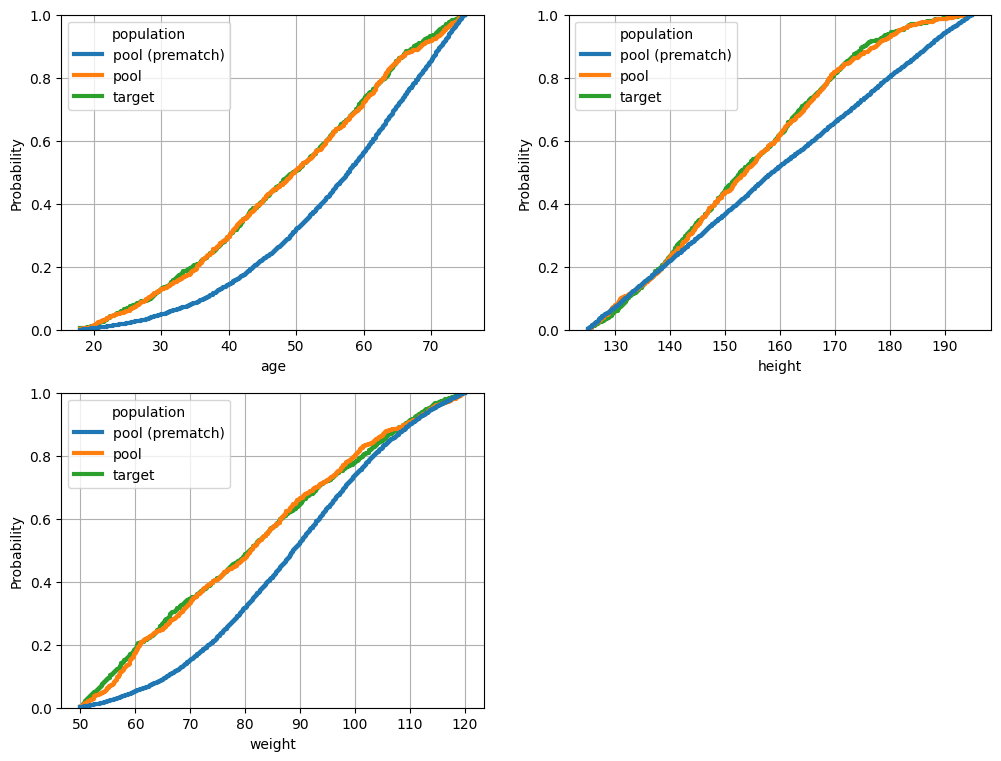

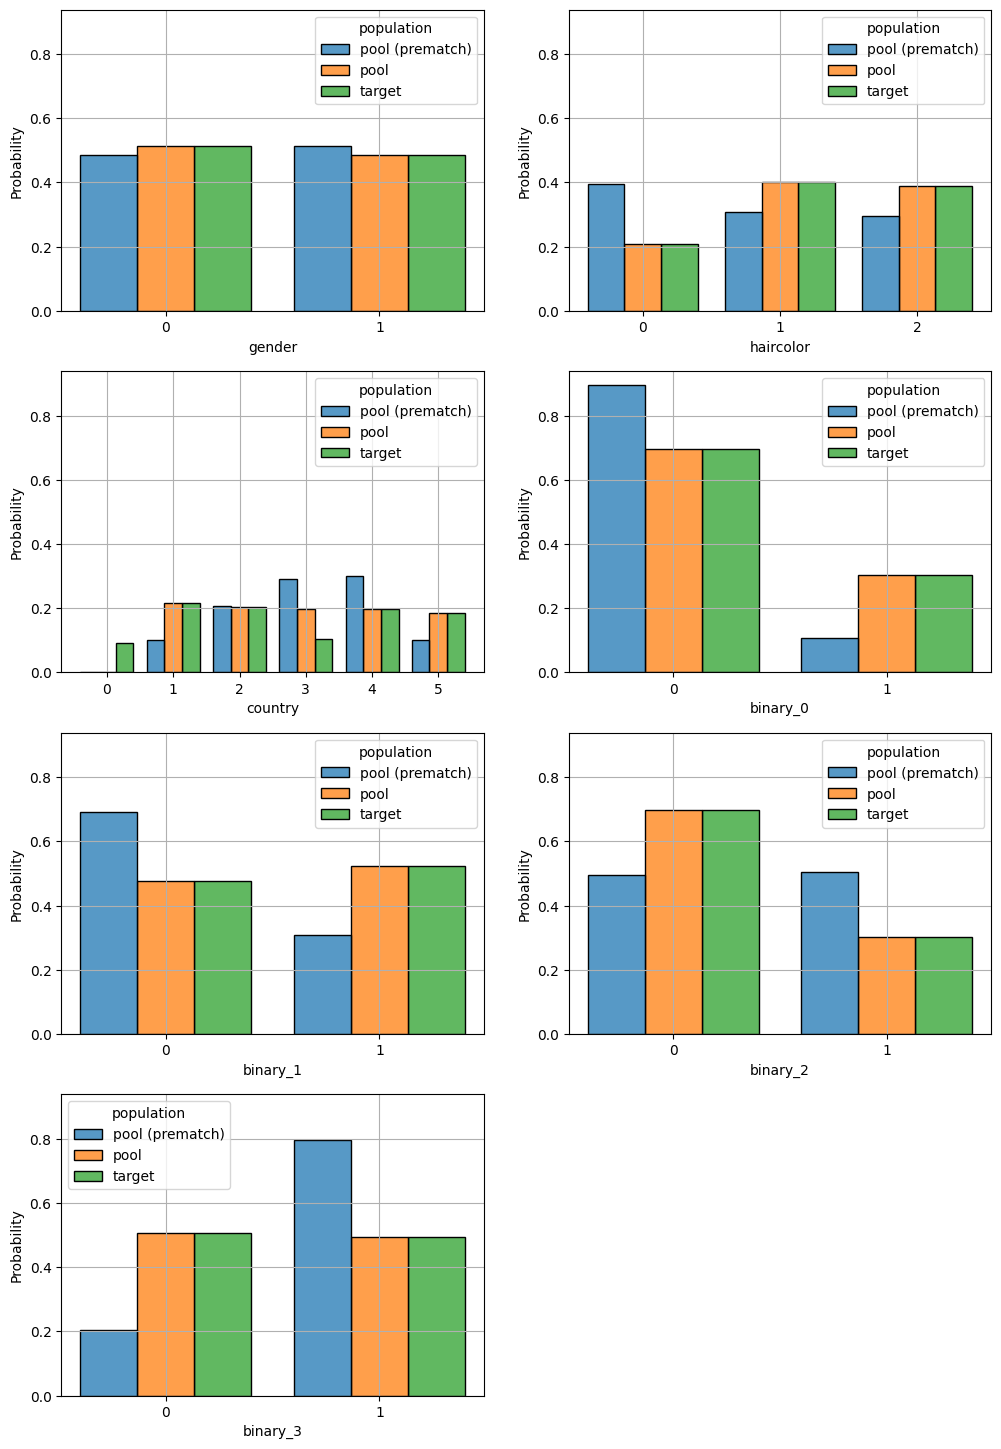

In [13]:
%matplotlib inline

match = matcher.get_best_match()
m_data = m.copy().get_population('pool')
m_data.loc[:, 'population'] = m_data['population'] + ' (prematch)'
match.append(m_data)
fig = plot_per_feature_loss(match, objective, 'target', debin=False)
fig = plot_numeric_features(match, hue_order=['pool (prematch)', 'pool', 'target', ])
fig = plot_categoric_features(match,  hue_order=['pool (prematch)', 'pool', 'target'])